<a href="https://colab.research.google.com/github/Ghul2002/NYHA-Classification/blob/main/nyha_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [276]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from imblearn.over_sampling import SMOTE

In [277]:
df = pd.read_csv('data.csv', sep=';')
df.columns = df.iloc[0]
df = df[1:].copy()
df = df.reset_index(drop=True)
print(df.shape)
df.head()

(469, 64)


,ID CODES,DEATH?,DEATHDATE,TIMEFU,QOL,OQLsub1,OQLsub2,DOB,DOE,AGE,...,EXERCISE5,CPX.TIME,CPX.PEAKVO2,CPX.PEAKVO2FORBM,RER,SLOPE,METS,WEBER,PEAK>18,SLOPE>35
0,HB1,0,3-2-2012,2076,27,23,4,14-6-1959,29-5-2006,"46,99",...,-10,"14,523","2577,8","23,98","1,04","37,485",7,1,1,1
1,HB2,0,12-8-2012,2316,42,37,5,22-12-1958,10-4-2006,"47,33",...,-13,"17,267","1555,8","22,22",1,"37,232","6,348571429",1,1,1
2,HB3,0,21-2-2012,2349,0,0,0,25-11-1945,16-9-2005,"59,85",...,-22,"15,195","1748,6","21,86","1,17","44,719","6,245714286",1,1,1
3,HB4,0,3-2-2013,2459,10,7,3,20-3-1945,12-5-2006,"61,19",...,-38,"13,45","1799,8","20,58","1,16","39,423","5,88",1,1,1
4,HB5,0,3-2-2013,2629,4,2,2,7-3-1982,23-11-2005,"23,73",...,4,"16,38","2626,4","26,54","1,21","21,051","7,582857143",1,1,0


In [278]:
nan_counts = df.isna().sum()
cols_to_keep = nan_counts[nan_counts < 60].index.tolist()
df= df[cols_to_keep]
print(df.shape)

(469, 36)


In [279]:
print(df.isna().sum().sum())
df.head()

775


,ID CODES,DOB,DOE,AGE,HEIGHT.CM,WEIGHT.KG,BMI,LVEF.0,NYHA,AETH.HF,...,EXERCISE1,EXERCISE2,EXERCISE3,6MWT.DIST,6MWT.SBP1,6MWT.DBP1,6MWT.HR1,6MWT.SBP2,6MWT.DBP2,6MWT.HR2
0,HB1,14-6-1959,29-5-2006,"46,99",170,116,"40,1",38,2,1,...,"7,5",9,11,395,160,120,96,150,110,72
1,HB2,22-12-1958,10-4-2006,"47,33",165,70,"25,7",25,2,1,...,7,13,12,330,125,80,72,115,80,65
2,HB3,25-11-1945,16-9-2005,"59,85",177,80,"25,5",30,1,2,...,4,13,14,585,170,90,76,165,90,72
3,HB4,20-3-1945,12-5-2006,"61,19",173,"87,5","29,2",30,1,1,...,7,14,13,548,160,80,72,140,80,64
4,HB5,7-3-1982,23-11-2005,"23,73",180,99,"30,6",45,1,2,...,3,19,24,720,150,80,104,130,80,92


In [280]:
df.columns = df.columns.str.strip()
df = df.drop(['ID CODES', 'DOB', 'DOE'], axis=1, errors='ignore')
print(df.shape)

(469, 33)


In [281]:
for col in df.columns:
  if df[col].dtype == 'object':
    df[col] = df[col].str.replace(',', '.').astype(float, errors='ignore')
df['BNP'] = pd.to_numeric(df['BNP'], errors='coerce')

In [282]:
for col in df.columns:
    if df[col].dtype in ['float64', 'int64']:
        df[col] = df[col].fillna(df[col].median())
    else:
        try:
            df[col] = df[col].astype(float)
            df[col] = df[col].fillna(df[col].median())
        except:
            df[col] = df[col].fillna(df[col].mode()[0])

In [283]:
print(df.dtypes)
print(df.shape)

0
AGE          float64
HEIGHT.CM    float64
WEIGHT.KG    float64
BMI          float64
LVEF.0       float64
NYHA         float64
AETH.HF      float64
MI           float64
AF           float64
DM           float64
COPD         float64
STROKE       float64
ACEI.ARB     float64
BB           float64
MRA          float64
DIUR         float64
ANTIPLAT     float64
STATIN       float64
DIGOX        float64
HB           float64
NaN          float64
K            float64
BNP          float64
EXERCISE1    float64
EXERCISE2    float64
EXERCISE3    float64
6MWT.DIST    float64
6MWT.SBP1    float64
6MWT.DBP1    float64
6MWT.HR1     float64
6MWT.SBP2    float64
6MWT.DBP2    float64
6MWT.HR2     float64
dtype: object
(469, 33)


In [284]:
print(df['NYHA'].unique())
print(df['NYHA'].value_counts(dropna=False))

[2.  1.  3.  4.  1.5 2.5 3.5]
NYHA
2.0    231
3.0    125
1.0     77
2.5     16
4.0     10
1.5      8
3.5      2
Name: count, dtype: int64


In [285]:
def nyha_clean(x):
    if x in [1, '1', 1.5, '1,5']:
        return 1
    elif x in [2, '2', 2.5, '2,5']:
        return 2
    elif x in [3, '3', 3.5, '3,5']:
        return 3
    elif x in [4, '4']:
        return 4
    else:
        return None

df['NYHA_CLEAN'] = df['NYHA'].apply(nyha_clean)
print(df['NYHA_CLEAN'].value_counts(dropna=False))
print(df.shape)

NYHA_CLEAN
2    247
3    127
1     85
4     10
Name: count, dtype: int64
(469, 34)


In [286]:
X = df.drop('NYHA_CLEAN', axis=1)
X.columns = X.columns.astype(str)
y = df['NYHA_CLEAN']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(y_train.value_counts(), y_test.value_counts())

NYHA_CLEAN
2    197
3    102
1     68
4      8
Name: count, dtype: int64 NYHA_CLEAN
2    50
3    25
1    17
4     2
Name: count, dtype: int64


In [287]:
smote = SMOTE(random_state=42)
X_train_os, y_train_os = smote.fit_resample(X_train, y_train)
print("Class Distribution before SMOTE:")
print(y_train.value_counts())
print("\nClass Distribution after SMOTE:")
print(y_train_os.value_counts())

Class Distribution before SMOTE:
NYHA_CLEAN
2    197
3    102
1     68
4      8
Name: count, dtype: int64

Class Distribution after SMOTE:
NYHA_CLEAN
3    197
2    197
1    197
4    197
Name: count, dtype: int64


In [288]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_os, y_train_os)

RandomForestClassifier(random_state=42)

In [289]:
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9787234042553191

Classification:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        17
           2       0.98      1.00      0.99        50
           3       0.96      0.96      0.96        25
           4       1.00      0.50      0.67         2

    accuracy                           0.98        94
   macro avg       0.99      0.86      0.90        94
weighted avg       0.98      0.98      0.98        94



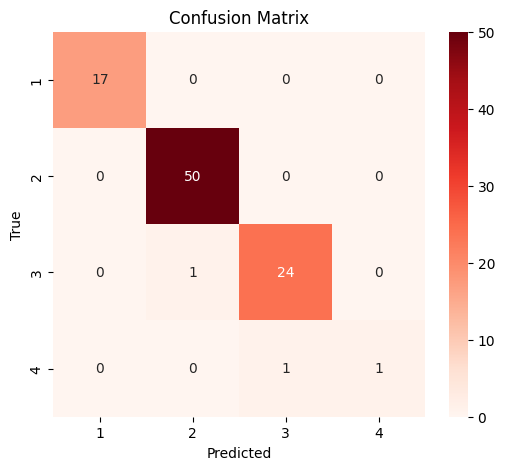

In [290]:
labels = [1, 2, 3, 4]
cm = confusion_matrix(y_test, y_pred, labels=labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=labels,
            yticklabels=labels)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()